# Anime Recommendation System
In this notebook we will construct a recommendation system (RecSys) using explicit anime rating data collected from multiple users on https://myanimelist.net/. The [dataset](https://www.kaggle.com/CooperUnion/anime-recommendations-database#anime.csv) consists of item preference data from 73,516 users on 12,294 different anime TV series, movies, OVAs, etc.

## Index

* [1.0 Data Cleaning, EDA, Feature Transformation](#1.0-Data-Cleaning,-EDA,-Feature-Transformation)
    * [1.1 Rating Data](#1.1-Rating-Data)
    * [1.2 Anime Data](#1.2-Anime-Data)
* [2.0 Evaluation](#2.0-Evaluation)
    * [2.1 Selecting a Metric](#2.1-Selecting-a-Metric)
    * [2.2 Methodology](#2.2-Methodology)
    
* [3.0 Baseline Recommender](#3.0-Baseline-Recommender)
* [4.0 Content-Based Filtering](#4.0-Content-Based-Filtering)
    * [4.1 Feature Normalization](#4.1-Feature-Normalization)
    * [4.2 Making Recommendations](#4.2-Making-Recommendations)
* [5.0 Collaborative Filtering](#5.0-Collaborative-Filtering)
    * [5.1 User-Based Collaborative Filtering](#5.1-User-Based-Collaborative-Filtering)
    * [5.2 Item-Based Collaborative Filtering](#5.2-Item-Based-Collaborative-Filtering)
    * [5.3 Matrix Factorization](#5.3-Matrix-Factorization)


    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 80)

## 1.0 Data Cleaning, EDA, Feature Transformation
First we'll import our data and familiarize ourselves with it to see if any preprocessing is required. User rating data is stored in `rating.csv`, while item data is stored in `anime.csv`.

In this case, we are using **explicit rating data** since the item ratings were chosen by users themselves. Another type of data that is more abundant for most recommendation problems is **implicit data**, where item ratings are inferred from user interactions. User interactions could consist of page views, purchases, likes, follows, comments, etc.

### 1.1 Rating Data
The user rating data provided has the following columns:
- `user_id` - non identifiable unique user id.
- `anime_id` - the anime that this user has rated.
- `rating` - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

In [2]:
# Load user rating data
root = os.getcwd()
user_data_path = os.path.join(root, "data", "rating.csv") 
user_ratings = pd.read_csv(user_data_path)

# Initial inspection
print(user_ratings.dtypes)
user_ratings.head()

user_id     int64
anime_id    int64
rating      int64
dtype: object


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [3]:
# Check missing value counts
pd.isnull(user_ratings).sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [4]:
# Drop duplicate entries
user_ratings.drop_duplicates(subset=['user_id','anime_id'],
                             inplace=True)

user_ratings.reset_index(inplace=True, drop=True)

print(user_ratings.shape)

(7813730, 3)


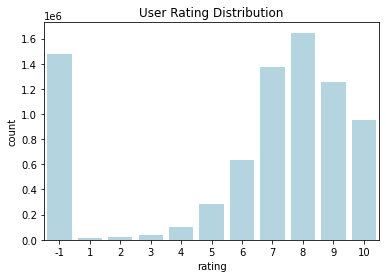

count    7.813730e+06
mean     6.144028e+00
std      3.727801e+00
min     -1.000000e+00
25%      6.000000e+00
50%      7.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64


In [5]:
# Raw rating distribution
sns.countplot(user_ratings['rating'],
              color='lightblue').set_title('User Rating Distribution')
plt.show()
print(user_ratings.describe()['rating'])

Inspecting the initial distribution of ratings indicates that a large proportion of users which marked the anime as 'watched' haven't actually provided a rating (as indicated by the `-1` values). The distribution of provided ratings is left/negatively skewed on a 1-10 integer scale.

This is normal behavior for users and results in a sparse distribution of item ratings. We will relabel all `-1` values to `0`.

In [6]:
# Flag missing ratings with 0
user_ratings.loc[user_ratings['rating'] == -1, 'rating'] = 0

### 1.2 Anime Data
The dataset of anime data is comprised of the following information:

- `anime_id` - myanimelist.net's unique id identifying an anime.
- `name` - full name of anime.
- `genre` - comma separated list of genres for the anime.
- `type` - movie, TV, OVA, etc.
- `episodes` - how many episodes in this show.
- `rating` - average rating out of 10.
- `members` - number of community members that are in this anime's "group".

In [7]:
# Load anime data
anime_data_path = os.path.join(root, "data", "anime.csv") 
anime = pd.read_csv(anime_data_path)

# Initial inspection
print(anime.dtypes)
anime.head()

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [8]:
# Check missing value counts
pd.isnull(anime).sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Since there are missing values in some of the columns, they should be cleaned up if we are going to use them as features. We will create two seperate dataframes for the anime information, one with only average rating info, and the other with all features.

In [9]:
# Index null ratings
idx_null_rating = pd.Index(anime['rating']).isnull()

anime = anime.loc[~idx_null_rating]  # Drop null rows from 'rating'
anime.drop_duplicates(inplace=True)  # Drop duplicates


# Check if anime_id's are consistent between user_ratings dataframe to avoid indexing errors later
ur_anime_ids = user_ratings['anime_id'].unique()
all_anime_ids = anime.anime_id.values

for anime_id in ur_anime_ids:
    if anime_id not in all_anime_ids:
        user_ratings = user_ratings.loc[~(user_ratings['anime_id']==anime_id)]

for anime_id in all_anime_ids:
    if anime_id not in ur_anime_ids:
        anime = anime.loc[~(anime['anime_id']==anime_id)]        

user_ratings = user_ratings.reset_index(drop=True)


anime.reset_index(inplace=True, drop=True)

# Ratings only
anime_ratings = anime.drop(columns=['genre','type','episodes','members'])

print(pd.isnull(anime_ratings).sum())
anime_ratings = anime_ratings.set_index('anime_id', verify_integrity=True)
anime_ratings.head()

anime_id    0
name        0
rating      0
dtype: int64


,name,rating
anime_id,,
32281,Kimi no Na wa.,9.37
5114,Fullmetal Alchemist: Brotherhood,9.26
28977,Gintama°,9.25
9253,Steins;Gate,9.17
9969,Gintama&#039;,9.16


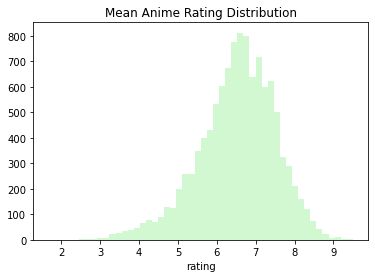

count    11194.000000
mean         6.514979
std          0.990543
min          1.670000
25%          5.940000
50%          6.590000
75%          7.200000
max          9.500000
Name: rating, dtype: float64


In [10]:
sns.distplot(anime_ratings['rating'],
             color='lightgreen',
             kde=False).set_title('Mean Anime Rating Distribution')
plt.show()
print(anime_ratings.describe()['rating'])

The distribution of mean anime ratings appears to be normal with a mean of 6.5 and a std dev of 1.0. This agrees with the central limit theorem.

In [11]:
# Index null genres
idx_null_genre = pd.Index(anime['genre']).isnull()

anime_allfeatures = anime.loc[~idx_null_genre]  # Drop null rows from 'genre'


print(pd.isnull(anime_allfeatures).sum())
anime_allfeatures.head()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [12]:
### Cleaning 'episodes' column
# Drop rows with 'Unknown' 
idx_ep_unknown = (anime_allfeatures['episodes'] == 'Unknown')
anime_allfeatures = anime_allfeatures.loc[~idx_ep_unknown]

# To numeric
anime_allfeatures = anime_allfeatures.astype(dtype={'episodes':'int64'})

anime_allfeatures.reset_index(inplace=True, drop=True)

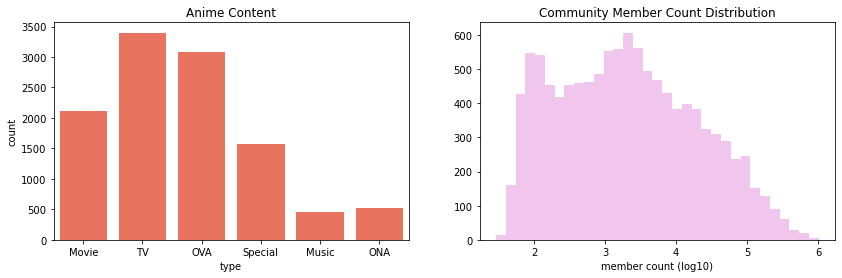

In [13]:
fig, axes = plt.subplots(1,2, figsize=(14,4))

# Plot type counts
sns.countplot(anime_allfeatures['type'],
              color='tomato',
              ax=axes[0]).set_title('Anime Content')



# Visualize Member distribution (log count)
sns.distplot(np.log10(anime_allfeatures['members'].rename('member count (log10)')),
             color='orchid',
             kde=False,
             ax=axes[1]).set_title('Community Member Count Distribution')

plt.show()


In order to process categorical features `genre` and `type`, we need to encode them numerically. We will do so by hot-encoding the categories into binary-valued columns.

In [14]:
## One hot-encode 'type'
anime_allfeatures = pd.get_dummies(anime_allfeatures,
                                   columns=['type'])

# Convert col from str to list
anime_allfeatures['genre'] = anime_allfeatures['genre'].str.split(', ')

# Binarize 'genre'
mlb = MultiLabelBinarizer()
genre_binarized = mlb.fit_transform(anime_allfeatures['genre'])
genre_binarized = pd.DataFrame(genre_binarized, 
                               columns=mlb.classes_,
                               index=anime_allfeatures.index)

# Join result to features df
anime_allfeatures = anime_allfeatures.join(genre_binarized, how='left')
anime_allfeatures.head()

,anime_id,name,genre,episodes,rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",1,9.37,200630,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",64,9.26,793665,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",51,9.25,114262,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",24,9.17,673572,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",51,9.16,151266,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


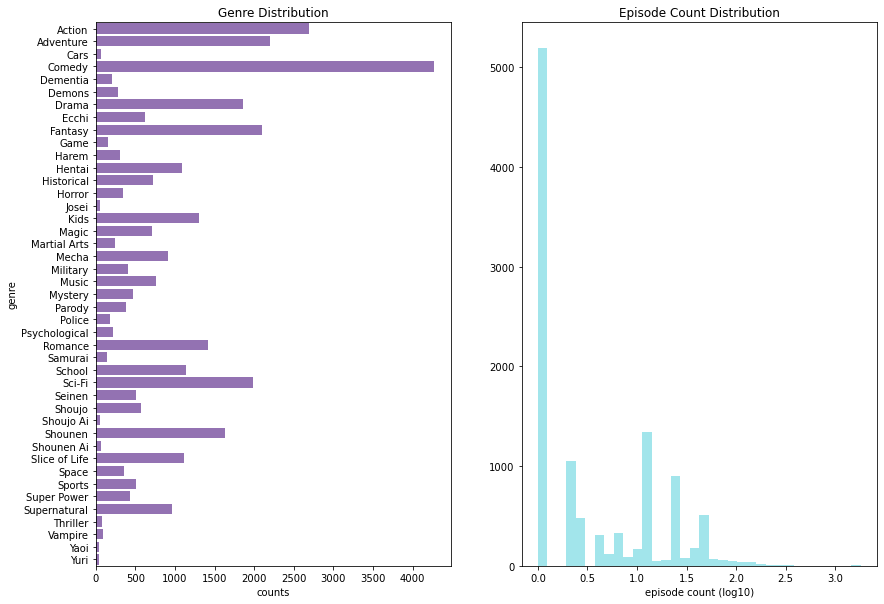

In [15]:
# Visualize Genre distribution
genre_counts = genre_binarized.sum()
genre_counts = genre_counts.to_frame(name='counts').reset_index()
genre_counts = genre_counts.rename(columns={'index':'genre'})

fig, axes = plt.subplots(1,2, figsize=(14,10))

# Plot type counts
sns.barplot(
    y='genre',
    x='counts',
    data=genre_counts,
    color='tab:purple',
    ax=axes[0]
).set_title('Genre Distribution')


# Visualize 'episodes' distribution
sns.distplot(np.log10(anime_allfeatures['episodes'].rename('episode count (log10)')),
             color='tab:cyan',
             kde=False,
             ax=axes[1]).set_title('Episode Count Distribution')

plt.show()

It is obvious that a large portion of anime is have *comedic* elements to them. Other popular genres include *Action*, *Adventure*, and *Fantasy*.

Scaling the distribution of episode by log10, reveals that most of the anime series have less than 10 episodes associated with them likely because movies, and OVAs are included in the data. A good portion of anime have more than 10 episodes, with a few of them having more than 50 episodes.

The episode counts can thus be binned into categorical features as a rough indicator of the length of the series:
- **few**: less than 10 episodes
- **moderate**: 10 to 50 episodes
- **many**: more than 50 episodes

Reducing the granularity of episode counts will allow for more descriptive features.

In [16]:
# One-hot encode categorical 'episodes' 
def categorize_episodes(episodes_col):
    if episodes_col < 10:
        return 'few'
    elif episodes_col <=50:
        return 'moderate'
    else:
        return 'many'

anime_allfeatures['episodes_category'] = anime_allfeatures['episodes'].apply(categorize_episodes)
anime_allfeatures = pd.get_dummies(anime_allfeatures,
                                   columns=['episodes_category'],
                                   prefix='episodes')


We will employ a similar strategy for categorizing and encoding the `members` feature since its distribution is quite sparse. The distribution will be categorized into 5 quantiles of (approximately) equal sizes:
- **1st quantile**: 0-20% of distribution
- **2nd quantile**: 20-40% of distribution
- **3rd quantile**: 40-60% of distribution
- **4th quantile**: 60-80% of distribution
- **5th quantile**: 60-100% of distribution

In [17]:
# Get 'members' quintile values
member_quantiles = [0.2, 0.4, 0.6, 0.8, 1.0]
quintile_names = ['Q1','Q2','Q3','Q4','Q5']

member_quant_vals = anime_allfeatures['members'].quantile(member_quantiles,
                                                          interpolation='nearest').values

print('`members` Quintile values:', list(member_quant_vals))

member_q_val_map = {}
for i in range(len(member_quant_vals)):
    member_q_val_map[member_quant_vals[i]] = quintile_names[i]

# Apply member categories
def categorize_members(members_col):
    for q_val in member_quant_vals:
        if members_col <= q_val:
            return member_q_val_map[q_val]

anime_allfeatures['members_quintile'] = anime_allfeatures['members'].apply(categorize_members)   

# One-hot encode 'members' (binned into quintiles)
anime_allfeatures = pd.get_dummies(anime_allfeatures,
                                   columns=['members_quintile'],
                                   prefix='members')

anime_allfeatures.head()

`members` Quintile values: [207, 964, 3344, 17038, 1013917]


,anime_id,name,genre,episodes,rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,episodes_few,episodes_many,episodes_moderate,members_Q1,members_Q2,members_Q3,members_Q4,members_Q5
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",1,9.37,200630,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",64,9.26,793665,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",51,9.25,114262,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",24,9.17,673572,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",51,9.16,151266,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


## 2.0 Evaluation
Since recommender systems are concerned with providing good rankings of items to different users, we need a way to differentiate the quality of a RecSys' recommendations. To do so, we need a way of testing a RecSys in an offline manner with ranking metrics.

While offline testing is important, the real performance of a RecSys depends on how much business value it brings once deployed online. In practice, this can be done by performing A/B testing.

### 2.1 Selecting a Metric
To measure how good a recommendation is, we need to quantify how well the items are ranked. Popular ranking metrics include **Mean Reciprocal Rank**, **Mean Average Precision (MAP@K)**, and **Normalized Discounted Cumulative Gain (NDCG@K)**. Since we are not ranking binary items (relevant / irrelevant) in this case and we have user rating on a numbered scale, we will use NDCG@K, with K representing the top K recommendations we would make to a user. NDCG@K assumes that items in the query which appear first are more important that those further down in the list, which is suitable since we would like to recommend the most relevant items first.

**Discounted Cumulative Gain (DCG@K)** of a ranked set of items is defined as:

$$ DCG_K = \sum\limits_{i=1}^{K} \frac{rel_i}{\log_2{(i+1)}} $$

- $rel_i$ - the true relevance of the result at position i (e.g. assigned rating score)
- $K$ - number of elements in the recommended ranking

_________________________

The best possible ranking of $K$ elements is represented as the **Idealized Discounted Cumulative Gain (IDCG@K)**

$$ IDCG_K = \sum\limits_{i=1}^{REL_K} \frac{rel_i}{\log_2{(i+1)}} $$

- $REL_K$ = the list of all corpus items ordered by decreasing relevance up to position $K$

_________________________


To normalize the DCG@K, we simply divide it by the IDCG@K to get the **Normalized Discounted Cumulative Gain (NDCG@K)**.

$$ NDCG_K = \frac{DCG_K}{IDCG_K} $$

_________________________

NDCG tells us how well we've ranked items offline for a user, so we simply take the average of all queries to estimate the performance of a recommendation engine. A few edge cases to consider are the following:

- When a user has no relevant documents the IDCG will be zero. In this case we need to manually set the NDCG to 0, to avoid division by zero.
- The size of the recommended list or ideal list can be less than K, so we need to pad the size of the list with the minimum DCG of 0 to have fixed length when computing NDCG@K.



In [18]:
def get_user_item_rating(user_id, item_id, user_ratings):
    '''Retrieves the rating a user has assigned to an item'''
    account_ratings = user_ratings.loc[user_ratings['user_id'] == user_id]
    assert account_ratings.shape[0] != 0, 'user_id does not exist or has not watched anything'
    try:
        #print(user_id, item_id)
        return account_ratings.loc[account_ratings['anime_id']==item_id, 'rating'].values[0]
    except IndexError:
        return 0  # Case where user has not watched the anime
    

# Define DCG
def DCG_K(ranked_ids, user_id, K, user_ratings):
    '''Computes Discounted Cumulative Gain for a user'''
    assert len(ranked_ids) <= K, 'Length of provided rankings greater than K'

    pad_value = 0
    dcg = 0
    
    for idx in range(K):
        i = idx+1
        try:
            item_id = ranked_ids[idx]
            rel = get_user_item_rating(user_id, item_id, user_ratings)
        except IndexError:
            rel = pad_value  # Pad if reqd
        dcg += rel / np.log2(i+1)       
    return dcg
        

# Define NDCG@K metric
def NDCG_K(recommendations, ideal_recs, user_id, K, user_ratings):
    '''Computes Normalized Discounted Cumulative Gain for a user/query'''
    
    # Compute DCG / IDCG
    dcg = DCG_K(recommendations, user_id, K, user_ratings)
    idcg = DCG_K(ideal_recs, user_id, K, user_ratings)
    
    if idcg == 0:
        return 0  #Avoid div by zero
    else:
        return dcg/idcg 


### 2.2 Methodology
Unlike the offline evaluation of traditional machine learning algorithms, data cannot be separated into independent training and testing sets. This is because recommenders typically need to have knowledge of a user during training to make recommendations for them during testing. The same holds true for items which can be recommended. Due to this, all users and items must be included during training and testing.

To create the testing set, we will use all of the user rating data as is. The training set however will consist of a proportion of user ratings randomly masked (removed). If the rating data was timestamped, we could mask the ratings input after a certain date instead of randomly. The goal of a RecSys then is to recommend the masked ratings as good recommendations for a user. A validation set can be created by doing the same to the training set.

In [19]:
def construct_rating_matrix(user_ratings_df, anime_df):
    '''RETURNS:
    - sparse rating matrix,
    - user id to matrix row index mapping
    - matrix row index to user id mapping
    - anime id to matrix col index mapping
    - matrix col index to anime id mapping
    '''
    # User and Anime ID's aren't in perfect chronological order
    # Map iloc to loc index so matrix indices can be mapped to ID's later
    rating_matrix_idx_user_id_map = user_ratings_df['user_id'].drop_duplicates().reset_index(drop=True).to_dict()
    user_id_rating_matrix_idx_map = {v: k for k, v in rating_matrix_idx_user_id_map.items()} #inverse map
    
    # Map iloc to loc index for anime_id
    rating_matrix_idx_anime_id_map = anime_df.reset_index()['anime_id'].to_dict()
    anime_id_rating_matrix_idx_map = {v: k for k, v in rating_matrix_idx_anime_id_map.items()} #inverse
    
    # Construct rating matrix (sparse format)
    n_users = len(rating_matrix_idx_user_id_map.keys())
    n_items = len(rating_matrix_idx_anime_id_map.keys())
    mat_shape = (n_users, n_items)   
    ratings = []
    row_idx = []
    col_idx = []
    nonzero_user_ratings = user_ratings_df.loc[user_ratings_df['rating']!=0]

    for row_tuple in nonzero_user_ratings.itertuples():
        i = user_id_rating_matrix_idx_map[row_tuple.user_id]
        j = anime_id_rating_matrix_idx_map[row_tuple.anime_id]
        row_idx.append(i)
        col_idx.append(j)
        ratings.append(row_tuple.rating)
        
    rating_matrix = csr_matrix((ratings, (row_idx, col_idx)),
                               shape=mat_shape)
    
    return (rating_matrix,
            user_id_rating_matrix_idx_map,
            rating_matrix_idx_user_id_map,
            anime_id_rating_matrix_idx_map,
            rating_matrix_idx_anime_id_map)
    

In [20]:
## Setup Evaluation Methods
def train_test_mask(user_ratings_df, anime_df, mask_frac=0.2, random_state=1):
    '''RETURNS:
    - masked user_ratings_df
    - train user_ratings_df
    - test user_ratings_df
    - train rating matrix
    - test rating matrix
    - rating matrix index mapping info
    '''
    np.random.seed(random_state) #set random state
    
    nz_user_ratings = user_ratings_df.loc[user_ratings_df.rating != 0]
    nz_ur_index = nz_user_ratings.index
    n_mask = int(mask_frac * len(nz_ur_index))
    
    # randomly mask non-zero ratings from user_ratings_df to get train user_ratings_df
    mask_idx = np.random.choice(nz_ur_index, n_mask, replace=False)
    masked_user_ratings_df = user_ratings_df.loc[mask_idx]
    
    train_user_ratings_df = user_ratings_df.copy()
    train_user_ratings_df.loc[mask_idx, 'rating'] = 0

    test_user_ratings_df = user_ratings_df
          
    # get train rating matrix, w/ mapping info
    (rating_matrix_TRAIN,
    user_id_rating_matrix_idx_map,
    rating_matrix_idx_user_id_map,
    anime_id_rating_matrix_idx_map,
    rating_matrix_idx_anime_id_map) = construct_rating_matrix(train_user_ratings_df, anime_df)
    
    # get test rating matrix, w/ mapping info
    (rating_matrix_TEST, _, _,  _, _) = construct_rating_matrix(test_user_ratings_df, anime_df)
    
    return (masked_user_ratings_df,
            train_user_ratings_df,
            test_user_ratings_df,
            rating_matrix_TRAIN,
            rating_matrix_TEST,
            user_id_rating_matrix_idx_map,
            rating_matrix_idx_user_id_map,
            anime_id_rating_matrix_idx_map,
            rating_matrix_idx_anime_id_map)
    

def get_ideal_recommendations(masked_user_ratings, user_id, K_max):
    '''Retrieves the best possible ranking of ratings for a user which were masked in the training data'''
    user_mask = masked_user_ratings.loc[masked_user_ratings['user_id']==user_id]
    user_mask = user_mask.sort_values('rating', ascending=False)
    
    # Limit max number of recommendations to K_max
    if user_mask.shape[0] > K_max:
        user_mask = user_mask.iloc[:K_max]
    
    return list(user_mask['anime_id'].values)



def evaluate_RecSys(model, masked_user_ratings, all_user_ratings, K=10):
    '''Computes the average NDCG@K over all users with ratings masking in the training data'''
    masked_users = masked_user_ratings['user_id'].unique()
    n_masked_users = len(masked_users)
    NDCG_sum = 0
    
    for user_id in tqdm(masked_users):
        model_recs = model.recommend(user_id, K)
        ideal_recs = get_ideal_recommendations(masked_user_ratings, user_id, K)
        NDCG_sum += NDCG_K(model_recs, ideal_recs, user_id, K, all_user_ratings)
        
    return NDCG_sum / n_masked_users
    

In [21]:
(masked_user_ratings_df,
train_user_ratings_df,
test_user_ratings_df,
rating_matrix_TRAIN,
rating_matrix_TEST,
user_id_rating_matrix_idx_map,
rating_matrix_idx_user_id_map,
anime_id_rating_matrix_idx_map,
rating_matrix_idx_anime_id_map) = train_test_mask(user_ratings, anime_ratings, mask_frac=0.2, random_state=1)


## 3.0 Baseline Recommender
A simple, often hard to beat baseline recommender is one which always recommends the most popular items which the user has not yet seen. We will use this naive popularity recommender to compare the relative performance of other more complex recommomender systems.

In [22]:
# Map anime_id to descriptive info
anime_infomap = anime[['anime_id','name','genre','type','episodes','rating','members']] \
.set_index('anime_id', verify_integrity=True) \
.sort_index() \
.transpose().to_dict('index')

## Utility functions ##
def get_watched(userID, user_ratings, masked_user_ratings=None):
    '''Returns anime which a user has already watched'''
    target_user_ratings = user_ratings.loc[user_ratings['user_id'] == userID]
    watched = set(target_user_ratings['anime_id'].values)
    
    # Filter any masked ratings provided (TRAIN / TEST EVALUATION PURPOSES)
    if masked_user_ratings is not None:
        anime_id_toMask = set(masked_user_ratings.loc[user_ratings['user_id']==userID, 'anime_id'].values)
        watched = watched - anime_id_toMask  #diff of sets
        
    if len(watched) == 0:
        print("user_id {0} does not exist or has not recorded anything as 'watched'".format(userID))
        
    return list(watched)



def tabulate_id_info(recommendations):
    '''Returns user recommendation list in a dataframe'''
    n_items = len(recommendations)
    rankings = np.arange(n_items) + 1
    
    names = []
    genres = []
    types = []
    episodes = []
    ratings = []
    members = []
    for anime_id in recommendations:
        try:
            names.append(anime_infomap['name'][anime_id])
            genres.append(anime_infomap['genre'][anime_id])
            types.append(anime_infomap['type'][anime_id])
            episodes.append(anime_infomap['episodes'][anime_id])
            ratings.append(anime_infomap['rating'][anime_id])
            members.append(anime_infomap['members'][anime_id])
        except KeyError:
            # if anime_id exists, but no info is available from the data provided
            names.append('n/a')
            genres.append('n/a')
            types.append('n/a')
            episodes.append('n/a')
            ratings.append('n/a')
            members.append('n/a')
        
    data = {'anime id':recommendations,
            'name': names,
            'genre': genres,
            'type': types,
            'episodes': episodes,
            'avg rating': ratings,
            'members': members}
    
    recs_df = pd.DataFrame(data=data, index=rankings)
    return recs_df


In [23]:
class popularRecommender:
    '''Popularity recommender instance'''
    
    def __init__(self, user_ratings, ratings_mask=None):
        self.ratings = user_ratings
        self.popular_ranking = np.array([]) #initialize as empty
        self.ratings_mask = ratings_mask
        
    def train(self):
        '''Ranks popularity of each anime(id) chronologically'''
        self.popular_ranking = self.ratings['anime_id'].value_counts().index
        
    def recommend(self, user_id, k):
        '''Recommends top k items to a user'''
        assert len(self.popular_ranking) != 0, 'Cannot recommend. Training required.'
        watched = get_watched(user_id, self.ratings, self.ratings_mask) # fetch seen items
        recommendations = []
        
        for anime_id in self.popular_ranking:
            if anime_id not in watched:
                recommendations.append(anime_id)
                
            if len(recommendations) == k:
                return recommendations
        
        # if ranking list is exhausted for large k
        print('k is larger than the number of possible recommendations.\n\
Recommendations with Cardinality less than k returned')
        return recommendations
        

With our popularity based recommender defined, we can retrieve sample top 10 recommendation for a user.

In [24]:
# Top 10 recommendations for user 1 - POPULARITY RECOMMENDER
popular_recsys = popularRecommender(user_ratings)
popular_recsys.train()
user_1_recs = popular_recsys.recommend(user_id=1, k=10)
tabulate_id_info(user_1_recs)

,anime id,name,genre,type,episodes,avg rating,members
1,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
2,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
3,121,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,51,8.33,600384
4,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
5,2904,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888
6,199,Sen to Chihiro no Kamikakushi,"Adventure, Drama, Supernatural",Movie,1,8.93,466254
7,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,657190
8,2167,Clannad,"Comedy, Drama, Romance, School, Slice of Life,...",TV,23,8.30,566690
9,11111,Another,"Horror, Mystery, School, Supernatural, Thriller",TV,12,7.88,534657
10,3588,Soul Eater,"Action, Adventure, Comedy, Fantasy, Shounen, S...",TV,51,8.08,580184


We can also evaluate the performance score (mean NDCG) of the baseline model.

In [25]:
# Evaluate baseline model
results_path = 'modelTestResults.csv'

popular_recsys = popularRecommender(train_user_ratings_df, masked_user_ratings_df)
popular_recsys.train()
model_name = 'Popularity Recommender (baseline)'

# Load results if saved
try:
    model_results = pd.read_csv(results_path) 
except FileNotFoundError:
    model_results = pd.DataFrame(columns=['name', 'Mean NDCG (K=10)'])
    model_results.to_csv(results_path, index=False)

    
if model_name not in model_results['name'].values:
    mean_NDCG = evaluate_RecSys(popular_recsys, masked_user_ratings_df, test_user_ratings_df, K=10)   
    
    row = [model_name, mean_NDCG]
    model_results.loc[len(model_results)] = row
    model_results.to_csv(results_path, index=False)


model_results

,name,Mean NDCG (K=10)
0,Popularity Recommender (baseline),0.156098


## 4.0 Content-Based Filtering
Recommender systems (RecSys) are typically grouped into two main categories: **content-based filtering**, and **collaborative filtering**. Content-based filtering RecSys aim to provide recommendations to a user based on the items that user has already interacted with. If a user has highly rated an item in the past, the content-based filtering will learn that user's preferences and recommend items matching the user's preferences and past interactions. 

To do this, we will need to encode items in a feature space. A user must also be able to be represented in this same feature space in order to capture his/her item preferences. A similarity measure could then be used to capture how relevant any item is to a user for personalized recommendations.

Like any model, it has advantages and disadvantages:
- **Advantages**
    - Does not require data of other users to make recommendations.
    - Good at capturing a user's niche item interests few people have interest in.
- **Disadvantages**
    - Lack of variety - the model will always recommend items similar to what the user has past interaction with, and will never recommend different types of items the user does not know about, but may like.
    - Model performance is heavily dependent on good feature engineering in order to represent items and users in the same feature space. Domain knowledge is often essential.

In [26]:
# Retrieve item feature representations
anime_features = anime_allfeatures.set_index('anime_id', verify_integrity=True)
anime_features = anime_features.drop(columns=['name','genre','episodes','rating','members'])
anime_features.head()

,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,episodes_few,episodes_many,episodes_moderate,members_Q1,members_Q2,members_Q3,members_Q4,members_Q5
anime_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32281,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
5114,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
28977,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
9253,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
9969,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


Note that the `rating` feature was dropped because content based filtering makes recommendations regardless of other users' input.

We need a rating matrix to represent each user's item preferences. A sparse matrix representation will be used for the rating matrix since there are a lot of users and items in the system. Most users have only seen a few of the whole collection of items, so the representation is more memory efficient.

In [27]:
# Check if anime_id's are consistent in user_ratings dataframe to avoid indexing errors later
ur_anime_ids = user_ratings['anime_id'].unique()
af_anime_ids = anime_features.index.values

cbf_user_ratings = user_ratings.copy()

for anime_id in ur_anime_ids:
    if anime_id not in af_anime_ids:
        cbf_user_ratings = cbf_user_ratings.loc[~(cbf_user_ratings['anime_id']==anime_id)]
        
for anime_id in af_anime_ids:
    if anime_id not in ur_anime_ids:
        anime_features = anime_features.drop(anime_id) 
        
# user ratings for content based filtering        
cbf_user_ratings = cbf_user_ratings.reset_index(drop=True)    


In [28]:
# Different split for content based filtering using anime_features dataframe
(cbf_masked_user_ratings_df,
cbf_train_user_ratings_df,
cbf_test_user_ratings_df,
cbf_rating_matrix_TRAIN,
cbf_rating_matrix_TEST,
cbf_user_id_rating_matrix_idx_map,
cbf_rating_matrix_idx_user_id_map,
cbf_anime_id_rating_matrix_idx_map,
cbf_rating_matrix_idx_anime_id_map) = train_test_mask(cbf_user_ratings, anime_features, mask_frac=0.2, random_state=1)

print(type(cbf_rating_matrix_TRAIN))
print(cbf_rating_matrix_TRAIN.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(73515, 11158)


In [29]:
# Get raw feature matrix
feature_matrix = anime_features.to_numpy(copy=True)
print(feature_matrix.shape)

(11158, 57)


### 4.1 Feature Normalization

With our user ratings matrix and feature matrix established, the next step would be to normalize each anime's binary features by the square root of the number of flagged features (flagged with 1). The normalization is necessary to avoid weighting items with more flagged features much heavier than those with less features.

Similiarly, we would want to avoid weighing some features more heavily than others, so we can also normalize each feature by the **inverse document frequency (IDF)**. Here our 'documents' would be users in this context.

IDF is computed as,

$
IDF = \log(\frac{N}{DF})
$

- **N** = total number of documents (users) in the corpus
- **DF** = document frequency, the number of documents where the term (feature) appears in the corpus


### 4.2 Making Recommendations

Recall that in order to recommend items to a user, we first need to represent the user in the same space as the items. In other words, we need to represent each user using the same features we've used to describe each item.

Assuming ***R*** represents the rating matrix for all users and items, and ***F*** is the feature matrix for each item, the user representation matrix ***U*** can be simply derived as follows, where each row represents a user's profile vector:

$
U = R \cdot F
$

To determine if a user's preferences align with an item, we need to compute a similarity metric. While many similarity metrics exist (cosine similarity, pearson correlation, etc.), we will chose the **dot product** as our metric in this case, with larger values indicating higher similarity.

$
similarity = u \cdot i
$
- **u** = a user's profile vector
- **i** = an item's feature representation

In [30]:
class CBFRecommender:
    '''Content-Based Filtering Recommender'''
    
    def __init__(self, rating_matrix, feature_matrix,
                 user_id_rating_matrix_idx_map,
                 rating_matrix_idx_user_id_map,
                 anime_id_rating_matrix_idx_map,
                 rating_matrix_idx_anime_id_map,
                 ratings_mask=None):
        
        # Normalize each item by number of features
        norm_vec = np.sqrt(np.sum(feature_matrix, axis=1))
        norm_feature_matrix = feature_matrix / norm_vec.reshape(-1,1)

        # Normalize each feature by with idf of the feature
        tf = np.sum(feature_matrix, axis=0)
        idf = np.log10(rating_matrix.shape[0] / tf)
        norm_feature_matrix = norm_feature_matrix * idf.reshape(1,-1)        
        
        self.F = csr_matrix(norm_feature_matrix) # normalized, sparse
        self.R = rating_matrix
        self.U = None   #stores user profiles
        
        self.uid_rmi_map = user_id_rating_matrix_idx_map
        self.rmi_uid_map = rating_matrix_idx_user_id_map
        self.aid_rmi_map = anime_id_rating_matrix_idx_map
        self.rmi_aid_map = rating_matrix_idx_anime_id_map
        self.ratings_mask = ratings_mask
        
        
    def train(self):
        '''Compute all user profile vectors'''
        self.U = np.dot(self.R, csr_matrix(self.F))
        
    def recommend(self, user_id, k):
        '''Recommends top k items to a user'''
        user_idx = self.uid_rmi_map[user_id]
        user_vec = self.U[user_idx]
        
        # dot product similarity score
        item_scores = np.dot(user_vec, self.F.T)
        item_scores = np.ravel(item_scores.todense())
        
        # Sort descending
        sorted_item_idx = np.argsort(item_scores)[::-1]
               
        # filter out already seen
        watched = get_watched(user_id, cbf_user_ratings, self.ratings_mask) # fetch seen items
        recommendations = []
              
        for item_idx in sorted_item_idx:
            candidate_anime_id = self.rmi_aid_map[item_idx]
            
            if candidate_anime_id not in watched:
                recommendations.append(candidate_anime_id)
                
            if len(recommendations) == k:
                return recommendations
            
        # if ranking list is exhausted for large k
        print('k is larger than the number of possible recommendations.\n\
Recommendations with Cardinality less than k returned')
        return recommendations
                

Using all of the given data, let's make a few sample recommendations for a user with our content-based filtering RecSys.

In [31]:
# Top 10 recommendations for user_id=10
cbf = CBFRecommender(cbf_rating_matrix_TEST, feature_matrix,
                     cbf_user_id_rating_matrix_idx_map,
                     cbf_rating_matrix_idx_user_id_map,
                     cbf_anime_id_rating_matrix_idx_map,
                     cbf_rating_matrix_idx_anime_id_map)
cbf.train()
recommendations = cbf.recommend(user_id=10, k=10)
tabulate_id_info(recommendations)

,anime id,name,genre,type,episodes,avg rating,members
1,17265,Log Horizon,"Action, Adventure, Fantasy, Game, Magic, Shounen",TV,25,8.14,387100
2,23321,Log Horizon 2nd Season,"Action, Adventure, Fantasy, Game, Magic, Shounen",TV,25,7.66,215817
3,29803,Overlord,"Action, Adventure, Fantasy, Game, Magic, Super...",TV,13,8.04,244268
4,2156,Bakugan Battle Brawlers,"Action, Fantasy, Game",TV,52,6.38,25846
5,10015,Yu☆Gi☆Oh! Zexal,"Action, Fantasy, Game, Shounen",TV,73,6.58,22480
6,20533,Z/X: Ignition,"Adventure, Fantasy, Game, Sci-Fi",TV,12,6.68,24788
7,20021,Sword Art Online: Extra Edition,"Action, Adventure, Fantasy, Game, Romance",Special,1,7.00,121722
8,873,.hack//Roots,"Adventure, Drama, Fantasy, Game, Sci-Fi",TV,26,7.06,50480
9,482,Yu☆Gi☆Oh!: Duel Monsters GX,"Action, Comedy, Fantasy, Game, Shounen",TV,180,7.23,74331
10,481,Yu☆Gi☆Oh! Duel Monsters,"Adventure, Game, Shounen",TV,224,7.57,132099


The recommendations above can then be compared to the anime already watched by the user, listed below.

In [32]:
# Already watched anime for user_id=10
tabulate_id_info(get_watched(userID=10, user_ratings=cbf_user_ratings))

,anime id,name,genre,type,episodes,avg rating,members
1,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
2,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
3,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
4,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
5,2581,Mobile Suit Gundam 00,"Action, Drama, Mecha, Military, Sci-Fi, Space",TV,25,8.24,120351
6,21881,Sword Art Online II,"Action, Adventure, Fantasy, Game, Romance",TV,24,7.35,537892
7,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
8,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917


A brief inspection reveals that the recommendations made are suitable based on the user's past interactions with similar genres.

Now let's evaluate the quality of the model's offline recommendations against the baseline model.

In [33]:
# Evaluate content-based filtering model
cbf_recsys = CBFRecommender(cbf_rating_matrix_TRAIN, feature_matrix,
                            cbf_user_id_rating_matrix_idx_map,
                            cbf_rating_matrix_idx_user_id_map,
                            cbf_anime_id_rating_matrix_idx_map,
                            cbf_rating_matrix_idx_anime_id_map,
                            cbf_masked_user_ratings_df)

cbf_recsys.train()
model_name = 'Content-Based Filtering'

# Load results if saved
try:
    model_results = pd.read_csv(results_path) 
except FileNotFoundError:
    model_results = pd.DataFrame(columns=['name', 'Mean NDCG (K=10)'])
    model_results.to_csv(results_path, index=False)

    
if model_name not in model_results['name'].values:
    mean_NDCG = evaluate_RecSys(cbf_recsys, cbf_masked_user_ratings_df, cbf_test_user_ratings_df, K=10)   
    
    row = [model_name, mean_NDCG]
    model_results.loc[len(model_results)] = row
    model_results.to_csv(results_path, index=False)


model_results

user_id 55861 does not exist or has not recorded anything as 'watched'
user_id 35396 does not exist or has not recorded anything as 'watched'
user_id 48885 does not exist or has not recorded anything as 'watched'
user_id 25343 does not exist or has not recorded anything as 'watched'
user_id 61966 does not exist or has not recorded anything as 'watched'
user_id 11014 does not exist or has not recorded anything as 'watched'
user_id 17218 does not exist or has not recorded anything as 'watched'
user_id 61431 does not exist or has not recorded anything as 'watched'
user_id 9913 does not exist or has not recorded anything as 'watched'
user_id 3711 does not exist or has not recorded anything as 'watched'
user_id 5126 does not exist or has not recorded anything as 'watched'
user_id 62488 does not exist or has not recorded anything as 'watched'
user_id 35097 does not exist or has not recorded anything as 'watched'
user_id 13925 does not exist or has not recorded anything as 'watched'
user_id 3

user_id 28492 does not exist or has not recorded anything as 'watched'
user_id 9387 does not exist or has not recorded anything as 'watched'
user_id 67885 does not exist or has not recorded anything as 'watched'
user_id 47907 does not exist or has not recorded anything as 'watched'
user_id 38900 does not exist or has not recorded anything as 'watched'
user_id 52863 does not exist or has not recorded anything as 'watched'
user_id 67597 does not exist or has not recorded anything as 'watched'
user_id 70813 does not exist or has not recorded anything as 'watched'
user_id 15635 does not exist or has not recorded anything as 'watched'
user_id 52721 does not exist or has not recorded anything as 'watched'
user_id 56528 does not exist or has not recorded anything as 'watched'
user_id 25816 does not exist or has not recorded anything as 'watched'
user_id 47710 does not exist or has not recorded anything as 'watched'
user_id 31772 does not exist or has not recorded anything as 'watched'
user_id

user_id 38786 does not exist or has not recorded anything as 'watched'
user_id 915 does not exist or has not recorded anything as 'watched'
user_id 52979 does not exist or has not recorded anything as 'watched'
user_id 21218 does not exist or has not recorded anything as 'watched'
user_id 52474 does not exist or has not recorded anything as 'watched'
user_id 56556 does not exist or has not recorded anything as 'watched'
user_id 10223 does not exist or has not recorded anything as 'watched'
user_id 27859 does not exist or has not recorded anything as 'watched'
user_id 29613 does not exist or has not recorded anything as 'watched'
user_id 44039 does not exist or has not recorded anything as 'watched'
user_id 60601 does not exist or has not recorded anything as 'watched'
user_id 42960 does not exist or has not recorded anything as 'watched'
user_id 44782 does not exist or has not recorded anything as 'watched'
user_id 45286 does not exist or has not recorded anything as 'watched'
user_id 

user_id 5288 does not exist or has not recorded anything as 'watched'
user_id 13672 does not exist or has not recorded anything as 'watched'
user_id 58066 does not exist or has not recorded anything as 'watched'
user_id 26607 does not exist or has not recorded anything as 'watched'
user_id 33759 does not exist or has not recorded anything as 'watched'
user_id 3679 does not exist or has not recorded anything as 'watched'
user_id 37960 does not exist or has not recorded anything as 'watched'
user_id 54894 does not exist or has not recorded anything as 'watched'
user_id 36341 does not exist or has not recorded anything as 'watched'
user_id 70446 does not exist or has not recorded anything as 'watched'
user_id 50416 does not exist or has not recorded anything as 'watched'
user_id 59651 does not exist or has not recorded anything as 'watched'
user_id 67511 does not exist or has not recorded anything as 'watched'
user_id 2607 does not exist or has not recorded anything as 'watched'
user_id 5

,name,Mean NDCG (K=10)
0,Popularity Recommender (baseline),0.156098
1,Content-Based Filtering,0.068068


From the results, it seem that content-based filtering does not come close to beating our baseline model. This could likely be improved by carefully selecting and engineering more descriptive features. In the next section we'll try a different approach.

## 5.0 Collaborative Filtering
Recommender systems using collaborative filtering (CF) focus on making recommendations for a user based on other users' item interactions. Unlike content-based filtering, CF is capable of recommending items the user would like, but would have never considered. Additionally, this family of recsys is not reliant on feature engineering to make good recommendations.

- **Advantages**
    - Can allow users to develop new interests.
    - Only requires a rating/feedback matrix.
    - Domain knowledge and good feature engineering is not necessary.
- **Disadvantages**
    - Suffers from the cold-start problem - a new item cannot be recommended if it has not been seen during training. Heuristics need to be used to generate recommendations in this case.
    - Difficult to incorporate item features.
    - Higher offline / online computation load.
    
<br> 

CF RecSys are divided into two main implementations:
- ***Memory-based*** - This implementation is further subdivided into two different approaches:
    - **User-based CF**: This approach assumes that users with similar historical item ratings have similar interests. Similarity scores between other users are computed for a target user. A nearest neighbours approach is taken to then predict the ratings of items the target user has not yet interacted with. 
    - **Item-based CF**: Assumes that items having same rating patterns by a group of users are good to recommend together since they are similar. New recommendations are thus made based on their similarity with highly rated items the user has interacted with in the past. <br> <br>
- ***Model-based***: Implementation focused on using machine learning models to recommend items to users. Model-based approaches include matrix factorization techniques, SVD, PCA, neural networks, and probabilistic methods.

### 5.1 User-Based Collaborative Filtering
The following approach will be taken to generate recommendations in user-based CF:
1. Calculate the similarity between **users**
2. Find the k-nearest neighbours to the user (i.e. most similar users to the target user)
3. Predict ratings based on the neighbourhood of user ratings.

To compute the similarity of two users, we simply compare the rating vectors of the two users. One of the most common similarity metrics which tend to provide the best results for user-based CF is **Pearson correlation**.

$$
sim_{\textrm{uv}} = 
\frac{\sum_{i\in{I_{\textrm{uv}}}} (r_{\textrm{ui}} - \overline{r}_\textrm{u}) (r_{\textrm{vi}} - \overline{r}_\textrm{v})}
{ 
\sqrt{ \sum_{i\in{I_{\textrm{uv}}}} (r_{\textrm{ui}} - \overline{r}_\textrm{u})^2 } 
\sqrt{ \sum_{i\in{I_{\textrm{uv}}}} (r_{\textrm{vi}} - \overline{r}_\textrm{v})^2 } 
}
$$
where,
- $ I_{\textrm{uv}} $ = set of items commonly rated by user $\textrm{u}$ , and user $\textrm{v}$
- $ r_{\textrm{ui}} $ = rating user $\textrm{u}$ gave to item $\textrm{i}$
- $ \overline{r}_\textrm{u} $ = average ratings from user $\textrm{u}$

Rating predictions for a user can then be computed for an item can then be computed as follows:

$$
\hat{r}_{\text{ui}} = 
\overline{r}_{\text{u}} +
\frac{\sum_{\text{v}\in{\text{N}_\text{u}}} \text{sim}_\text{uv} (r_{\textrm{vi}} - \overline{r}_\textrm{v}) }
{\sum_{\text{v}\in{\text{N}_\text{u}}} |\text{sim}_\text{uv}| }
$$
where,
- $\hat{r}_{\text{ui}}$ = predicted rating of item $\text{i}$ for user $\text{u}$ 
- $\text{N}_\text{u}$ = set of users in the neighbourhood of user $\text{u}$


In [34]:
class userBasedCF:
    '''User-based collaborative filtering Recommender'''
    def __init__(self, rating_matrix,
                 user_id_rating_matrix_idx_map,
                 rating_matrix_idx_user_id_map,
                 anime_id_rating_matrix_idx_map,
                 rating_matrix_idx_anime_id_map,
                 num_neighbours,
                 ratings_mask=None):
        
        self.R = rating_matrix
        self.uid_rmi_map = user_id_rating_matrix_idx_map
        self.rmi_uid_map = rating_matrix_idx_user_id_map
        self.aid_rmi_map = anime_id_rating_matrix_idx_map
        self.rmi_aid_map = rating_matrix_idx_anime_id_map
        self.ratings_mask = ratings_mask
        self.num_neighbours = num_neighbours
#         self.nn_user_map = {}
        
    
    def user_pearson_correlation(self, u, v):
        '''Returns the pearson correlation between user rating vectors u, v'''
        # get set of commonly rated item indices
        u_nonzero_flag = (u != 0)
        v_nonzero_flag = (v != 0)
        common_idx_flag = u_nonzero_flag & v_nonzero_flag

        # case where no common ratings between users
        if np.sum(common_idx_flag) == 0:
            return 0        


        u_common_nz = u[common_idx_flag]
        v_common_nz = v[common_idx_flag]

        # mean non-zero ratings for users
        u_mean = np.mean(u[u_nonzero_flag])
        v_mean = np.mean(v[v_nonzero_flag])

        num = np.sum( (u_common_nz - u_mean) * (v_common_nz - v_mean) )
        denom = np.sqrt(np.sum((u_common_nz - u_mean)**2)) * np.sqrt(np.sum((v_common_nz - v_mean)**2))
        
        if denom == 0:
            return 0
        return num / denom
    
    
    def k_user_neighbours(self, user_id, k):
        '''Returns the k nearest neighbour user_ids to a user'''
        user_index = self.uid_rmi_map[user_id]
        u_ratings = np.ravel(self.R[user_index].todense())
        
        user_correlations = [self.user_pearson_correlation(u_ratings, np.ravel(self.R[u_idx].todense()))
                             for u_idx in range(self.R.shape[0])]
            
        # return user_ids with top k similarities
        user_correlations = np.array(user_correlations)
        user_correlations[user_index] = -99 #remove target user, force to low value

        # filter top k, convert to user_ids
        neighbour_user_idx = np.argpartition(-user_correlations, np.arange(k))[:k] #sort top k, descending          
        neighbour_ids = [self.rmi_uid_map[u_idx] for u_idx in neighbour_user_idx]
        
        return neighbour_ids
    
    
#     def train(self):
#         '''Creates dictionary mapping each user_id to a list of nearest neighbour user_ids'''
#         print('Training...')
#         self.nn_user_map = [self.k_user_neighbours(user_id, self.num_neighbours) 
#                             for user_id in tqdm(user_id_rating_matrix_idx_map.keys())]
#         print('Training complete')
        
    
    def predict_rating(self, user_id, item_id, neighbour_user_ids):
        '''Returns a prediction of the rating of an item for a user'''
        user_index = self.uid_rmi_map[user_id]
        u_ratings = np.ravel(self.R[user_index].todense())
        nz_ratings = u_ratings[u_ratings!=0]
        u_mean = np.mean(nz_ratings)
        item_idx = self.aid_rmi_map[item_id]        
        num = 0
        denom = 0
        
        for neighbour_id in neighbour_user_ids:
            neighbour_idx = self.uid_rmi_map[neighbour_id]
            neighbour_ratings = np.ravel(self.R[neighbour_idx].todense())
            neighbour_nz_ratings = neighbour_ratings[neighbour_ratings!=0]
            
            similarity = self.user_pearson_correlation(u_ratings, neighbour_ratings)
            neighbour_mean_rating = np.mean(neighbour_nz_ratings)            
            neighbour_item_rating = neighbour_ratings[item_idx]
                     
            num += similarity * (neighbour_item_rating - neighbour_mean_rating)
            denom += np.abs(similarity)
            
        if denom==0:
            return u_mean
        else:
            return u_mean + num/denom
        
    
    def recommend(self, user_id, k):
        '''Recommends top k items to a user'''
        watched = get_watched(user_id, user_ratings, self.ratings_mask)
        recommendations = []
        rec_ratings = []
        neighbour_user_ids = self.k_user_neighbours(user_id, self.num_neighbours)
        #neighbour_user_ids = self.nn_user_map[user_id]
        
        for item_id in self.aid_rmi_map.keys():
            if item_id not in watched:
                item_rating = self.predict_rating(user_id, item_id, neighbour_user_ids)
                rec_ratings.append(item_rating)
                recommendations.append(item_id)
        
        recommendations = np.array(recommendations)
        rec_ratings = np.array(rec_ratings)
        rec_indices = np.argpartition(-rec_ratings, np.arange(k))[:k] #sort top-k indices
        recommendations = recommendations[rec_indices] #Recommend top-k based on rating
    
        return list(recommendations)
        
        

Making some sample recommendations with our user-based collaborative filtering recsys we get the following:

In [35]:
# Top 10 recommendations for user_id=10
# 20 nearest neighbours
user_CF = userBasedCF(rating_matrix_TEST,
                      user_id_rating_matrix_idx_map,
                      rating_matrix_idx_user_id_map,
                      anime_id_rating_matrix_idx_map,
                      rating_matrix_idx_anime_id_map,
                      num_neighbours=20)

recommendations = user_CF.recommend(user_id=10, k=10)
tabulate_id_info(recommendations)

,anime id,name,genre,type,episodes,avg rating,members
1,19815,No Game No Life,"Adventure, Comedy, Ecchi, Fantasy, Game, Super...",TV,12,8.47,602291
2,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
3,22199,Akame ga Kill!,"Action, Adventure, Fantasy",TV,24,7.84,492133
4,5680,K-On!,"Comedy, Music, School, Slice of Life",TV,13,7.87,386048
5,2001,Tengen Toppa Gurren Lagann,"Action, Adventure, Comedy, Mecha, Sci-Fi",TV,27,8.78,562962
6,9919,Ao no Exorcist,"Action, Demons, Fantasy, Shounen, Supernatural",TV,25,7.92,583823
7,18679,Kill la Kill,"Action, Comedy, School, Super Power",TV,24,8.23,508118
8,7791,K-On!!,"Comedy, Music, School, Slice of Life",TV,26,8.14,246276
9,2167,Clannad,"Comedy, Drama, Romance, School, Slice of Life,...",TV,23,8.30,566690
10,30276,One Punch Man,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,12,8.82,552458


Since this memory-based implementation requires the computation of nearest neighbours between all users, it is not very scalable to real world applications where a large number of users exist in the database. Since **scalability is a major disadvantage**, we will not perform an evaluation of this user-based collaborative filtering model.

In [45]:
# Evaluation with much smaller testing split
(masked_user_ratings_df2,
train_user_ratings_df2,
test_user_ratings_df2,
rating_matrix_TRAIN2,
rating_matrix_TEST2,
user_id_rating_matrix_idx_map2,
rating_matrix_idx_user_id_map2,
anime_id_rating_matrix_idx_map2,
rating_matrix_idx_anime_id_map2) = train_test_mask(user_ratings, anime_ratings, mask_frac=0.0001, random_state=1)

In [ ]:
# Evaluate user-based collaborative filtering model

user_CF = userBasedCF(rating_matrix_TRAIN2,
                      user_id_rating_matrix_idx_map2,
                      rating_matrix_idx_user_id_map2,
                      anime_id_rating_matrix_idx_map2,
                      rating_matrix_idx_anime_id_map2,
                      num_neighbours=10,
                      ratings_mask=masked_user_ratings_df2)

model_name = 'User-Based Collaborative Filtering'

# Load results if saved
try:
    model_results = pd.read_csv(results_path) 
except FileNotFoundError:
    model_results = pd.DataFrame(columns=['name', 'Mean NDCG (K=10)'])
    model_results.to_csv(results_path, index=False)

    
if model_name not in model_results['name'].values:
    mean_NDCG = evaluate_RecSys(user_CF, masked_user_ratings_df2, test_user_ratings_df2, K=10)   
    
    row = [model_name, mean_NDCG]
    model_results.loc[len(model_results)] = row
    model_results.to_csv(results_path, index=False)


model_results

### 5.2 Item-Based Collaborative Filtering
Similar to the user-based CF approach, item-based collaborative filtering involves constructing neighbourhoods based on similarities. As its name suggests, the similarity of items is compared in this implementation. Each item is simply represented as a vector of user ratings assigned to it.



The following approach will be taken to generate recommendations in item-based CF:
1. Calculate the similarity between **items**
2. Find the k-nearest neighbours to the item (i.e. most similar items to the target item)
3. Predict ratings based on the neighbourhood of item ratings.

The similarity of items is computed by comparing the rating vectors of two items. A popular similarity metric for item-based CF is **cosine similarity**. In our case we will use a varient called **adjusted cosine similarity** which accounts for user rating bias (some users generally rate items higher than others). This metric is computed as follows:

$$
\text{sim}_\text{ij} = \frac{
\sum_{\text{u}\in{\text{U}_\text{ij}}} (r_\text{ui} - \overline{r}_\text{u}) (r_\text{uj} - \overline{r}_\text{u})
}
{
\sqrt{\sum_{\text{u}\in{\text{U}_\text{i}}} (r_\text{ui} - \overline{r}_\text{u})^2}
\sqrt{\sum_{\text{u}\in{\text{U}_\text{j}}} (r_\text{uj} - \overline{r}_\text{u})^2}
}
$$

where,
- $ \text{U}_\text{i} $ = the set of users who rated item $\text{i} $
- $ \text{U}_\text{j} $ = the set of users who rated item $\text{j} $
- $ \text{U}_\text{ij} $ = the set of users who rated both items $\text{i} $ and $\text{j} $
- $ \overline{r}_\textrm{u} $ = average ratings from user $\textrm{u}$
- $ r_\text{ui} $ = the rating user $\textrm{u}$ gave item $\text{i}$

Rating predictions corresponding to an item and user can then be made:
$$
\hat{r}_{\text{ui}} = 
\overline{r}_{\text{i}} +
\frac{\sum_{\text{j}\in{\text{N}_\text{i}}} \text{sim}_\text{ij} (r_{\textrm{uj}} - \overline{r}_\textrm{j}) }
{\sum_{\text{j}\in{\text{N}_\text{i}}} |\text{sim}_\text{ij}| }
$$
where,
- $\hat{r}_{\text{ui}}$ = predicted rating of item $\text{i}$ for user $\text{u}$ 
- $\text{N}_\text{i}$ = set of items in the neighbourhood of item $\text{i}$
- $ \overline{r}_\textrm{i} $ = average rating given to item $\textrm{i}$

An item-based CF is advantageous over a user-based one when there are many more users than items in the system, as it has a lower computational load. Regardless, as a memory-based CF algorithm, it still suffers from scalability issues due to the computation of nearest neighbours.

In [ ]:
class itemBasedCF:
    '''Item-based collaborative filtering Recommender'''
    def __init__(self, rating_matrix,
                 user_id_rating_matrix_idx_map,
                 rating_matrix_idx_user_id_map,
                 anime_id_rating_matrix_idx_map,
                 rating_matrix_idx_anime_id_map,
                 num_neighbours,
                 ratings_mask=None):
        
        self.R = rating_matrix
        self.uid_rmi_map = user_id_rating_matrix_idx_map
        self.rmi_uid_map = rating_matrix_idx_user_id_map
        self.aid_rmi_map = anime_id_rating_matrix_idx_map
        self.rmi_aid_map = rating_matrix_idx_anime_id_map
        self.ratings_mask = ratings_mask
        self.num_neighbours = num_neighbours
        
    def item_cosine_similarity(self, i, j):
        '''Returns the adjusted cosine similarity between item rating vectors i, j'''
        # get set of user indices who rated both items
        i_nonzero_flag = (i != 0)
        j_nonzero_flag = (j != 0)
        common_idx_flag = i_nonzero_flag & j_nonzero_flag
        
        # case where no users who rated both items
        if np.sum(common_idx_flag)==0:
            return 0
        
        # compute average rating for each user in set Uij
        Uij_ratings = self.R[common_idx_flag]
        Uij_avg_ratings = []
        for row_idx in range(Uij_ratings.shape[0]):
            nz_ratings_idx = Uij_ratings[row_idx] != 0
            avg_rating = np.mean(Uij_ratings[row_idx][nz_ratings_idx])
            Uij_avg_ratings.append(avg_rating)
            
        Uij_avg_ratings = np.array(Uij_avg_ratings)
        
        r_ui = i[common_idx_flag]
        r_uj = j[common_idx_flag]
        
        num = np.sum(np.multiply(r_ui - Uij_avg_ratings, r_uj - Uij_avg_ratings))
        
        # compute average rating for each user in set Ui
        Ui_ratings = self.R[i_nonzero_flag]
        Ui_avg_ratings = []
        for row_idx in range(Ui_ratings.shape[0]):
            nz_ratings_idx = Ui_ratings[row_idx] != 0
            avg_rating = np.mean(Ui_ratings[row_idx][nz_ratings_idx])
            Ui_avg_ratings.append(avg_rating)
        
        Ui_avg_ratings = np.array(Ui_avg_ratings)
        
        # compute average rating for each user in set Uj
        Uj_ratings = self.R[j_nonzero_flag]
        Uj_avg_ratings = []
        for row_idx in range(Uj_ratings.shape[0]):
            nz_ratings_idx = Uj_ratings[row_idx] != 0
            avg_rating = np.mean(Uj_ratings[row_idx][nz_ratings_idx])
            Uj_avg_ratings.append(avg_rating)
        
        Uj_avg_ratings = np.array(Uj_avg_ratings)
        
        r_ui = i[i_nonzero_flag]
        r_uj = j[j_nonzero_flag]
                
        denom = np.sqrt(np.sum( (r_ui - Ui_avg_ratings)**2 )) * np.sqrt(np.sum( (r_uj - Uj_avg_ratings)**2 ))            
        if denom == 0:
            return 0
        return num / denom
    
    
    def k_item_neighbours(self, item_id, k):
        '''Returns the k nearest neighbour item_ids to an item'''
        item_index = self.aid_rmi_map[item_id]
        item_ratings = np.ravel(self.R[:, item_index].todense())
        
        item_correlations = [self.item_cosine_similarity(item_ratings, np.ravel(self.R[i_idx].todense()))
                             for i_idx in range(self.R.shape[1])]
            
        # return item_ids with top k similarities
        item_correlations = np.array(item_correlations)
        item_correlations[item_index] = -99 #remove target item, force to low value

        # filter top k, convert to item_ids
        neighbour_item_idx = np.argpartition(-item_correlations, np.arange(k))[:k] #sort top k, descending          
        neighbour_ids = [self.rmi_aid_map[i_idx] for i_idx in neighbour_item_idx]
        
        return neighbour_ids
    
    
    def predict_rating(self, user_id, item_id, neighbour_item_ids):
        '''Returns a prediction of the rating of an item for a user'''
        
        
        
#         user_index = self.uid_rmi_map[user_id]
#         u_ratings = np.ravel(self.R[user_index].todense())
#         nz_ratings = u_ratings[u_ratings!=0]
#         u_mean = np.mean(nz_ratings)
#         item_idx = self.aid_rmi_map[item_id]        
#         num = 0
#         denom = 0
        
#         for neighbour_id in neighbour_user_ids:
#             neighbour_idx = self.uid_rmi_map[neighbour_id]
#             neighbour_ratings = np.ravel(self.R[neighbour_idx].todense())
#             neighbour_nz_ratings = neighbour_ratings[neighbour_ratings!=0]
            
#             similarity = self.user_pearson_correlation(u_ratings, neighbour_ratings)
#             neighbour_mean_rating = np.mean(neighbour_nz_ratings)            
#             neighbour_item_rating = neighbour_ratings[item_idx]
                     
#             num += similarity * (neighbour_item_rating - neighbour_mean_rating)
#             denom += np.abs(similarity)
            
#         if denom==0:
#             return u_mean
#         else:
#             return u_mean + num/denom
    
    
    
    def recommend(self, user_id, k):
        '''Recommends top k items to a user'''
        
        
#         watched = get_watched(user_id, user_ratings, self.ratings_mask)
#         recommendations = []
#         rec_ratings = []
#         neighbour_user_ids = self.k_user_neighbours(user_id, self.num_neighbours)
#         #neighbour_user_ids = self.nn_user_map[user_id]
        
#         for item_id in self.aid_rmi_map.keys():
#             if item_id not in watched:
#                 item_rating = self.predict_rating(user_id, item_id, neighbour_user_ids)
#                 rec_ratings.append(item_rating)
#                 recommendations.append(item_id)
        
#         recommendations = np.array(recommendations)
#         rec_ratings = np.array(rec_ratings)
#         rec_indices = np.argpartition(-rec_ratings, np.arange(k))[:k] #sort top-k indices
#         recommendations = recommendations[rec_indices] #Recommend top-k based on rating
    
#         return list(recommendations)

### 5.3 Matrix Factorization

### References
1. https://developers.google.com/machine-learning/recommendation
2. https://www.analyticsvidhya.com/blog/2015/08/beginners-guide-learn-content-based-recommender-systems/
3. http://fastml.com/evaluating-recommender-systems/
4. https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832
5. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8506344
6. http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf